In [ ]:
# 首先什么是内存泄露
# 即存在某些变量，当前已经不再被使用，但是又没有被释放。故而这个时候需要做垃圾回收操作。

# 哪些情况下会有内存泄露
# 1、对象被另一个生命周期特别长的对象所引用，比如某个全局对象统一管理了若干个子对象，部分子对象使用过一次后就不再被使用了
# 2、循环引用中的对象定义了__del__函数，关于循环引用对象，下面再提

# 垃圾回收在实际工程中的应用：
# 1、写代码过程中注意及时释放未来不再使用的变量：
#               比如执行del来手动地删除掉带有大量数据的变量，然后执行gc.collect()，从而能够及时释放出资源，从而提升内存的利用率
# 2、当发生了内存溢出时，或者有内存泄露时，可以用来排查问题。
#               下面有示例，即主要使用gc.set_debug(gc.DEBUG_COLLECTABLE)和gc.collect()配合使用来初步查看循环引用对象
#                或者使用gc.set_debug(gc.DEBUG_SAVEALL)、gc.collect()和gc.garbage遍历来精确查找，并使用objgraph.show_backrefs来形象展示观看
# 3、当然，最重要的是，了解了问题本质，也能防范于未然

In [ ]:
#在python中，主要是使用三大技术来做垃圾清理回收：1、引用计数 2、分代收集 3、标记清除

# 从大体上来说
# 引用计数 主要用于统计对象被引用的变量数，即主要用于判定，判定该对象是否可以被删除
# 分代收集 有点触发器的感觉，即达到每一代的域值条件会触发垃圾回收的执行
# 标记清除 则是对引用计数的弥补，因为引用计数解决不了“循环引用”类型的垃圾，故而标记清除主要用于解决循环引用问题

In [ ]:
# 引用计数（References count）：每个Python对象都有一个计数器，记录着当前有多少个变量指向这个对象。
# 将一个对象直接或者间接赋值给一个变量时，对象的计数器会加1；当变量被del删除，或者离开变量所在作用域时，对象的引用计数器会减1。
# 当计数器归零的时候，代表这个对象再也没有地方可能使用了，因此可以将对象安全的销毁，也就是可以被删了，但是并不是达到即删。
# 引用计数虽然需要一个额外的字段来统计每个对象的引用情况，但这只是很小的开销，相比内存泄露还是性价比很高。

In [ ]:
# 分代回收：
# 首先，Python将所有对象根据"生存时间"分为3代, 从0到2。
# 新创建的对象都分配为第0代。
# 每一代的清理频率有所差别，可以通过gc.set_threshold(threshold0[, threshold1[, threshold2]])来自己设定
# 当新增对象数量减去被删除对象数量的结果值大于threshold0时, Python会对第0代对象执行一次垃圾回收，这里的删除指的是手动del，并不是垃圾回收的删除
# 对第0代经过一次垃圾回收之后，第0代中未被清理掉的会被放入第1代中
# 当第0代被检查的次数超过了threshold1时, 第1代对象就会被执行一次垃圾回收。对第1代经过一次垃圾回收之后，第1代中未被清理掉的会被放入第2代中。
# 当第1代被检查的次数超过了threshold2时, 第2代对象也会被执行一次垃圾回收

#分代回收的原理依据是：认为，越年轻的越容易死去，比如局部对象。越年长的越容易存活，比如全局对象，类对象等。

In [ ]:
# 标记清除：
# 首先，标记清除是对引用计数的一个补充，其目的是为了解决那些引用计数解决不了的存在“循环引用”的对象
# 在Python中, 所有能够引用其他对象的对象都被称为容器，因此只有容器之间才可能形成循环引用，非容器对象也可以引用，但不会构成循环引用
# Python用双向链表来存储所有容器, 因为方便中插入和删除对象
# 因此在垃圾回收时，按以下步骤来处理那些循环引用对象
# 1、对每个容器对象, 设置一个gc_refs值, 初始化为该对象的引用计数值
# 2、对每个容器对象, 找到所有其引用的对象, 将被引用对象的gc_refs值减1。 比如A引用了B和C，则对B和C的gc_refs值减1，表示去掉与A的联系
# 3、执行完第2步后，所有gc_refs值还大于0的对象，表明至少存在一个非循环引用还在引用着，故而不能删，放到一个集合中
# 4、第三步被拎出来的对象，其引用着的对象也不能删，故而再拎出来一批
# 5、剩下的则是属于循环引用对象了，释放掉。

In [ ]:
#垃圾回收被触发的三种情况：
#   1、达到了垃圾回收的阈值，Python虚拟机自动执行
#   2、手动调用gc.collect()
#   3、Python虚拟机退出的时候

In [ ]:
#另外一些垃圾回收中的常见概念：
# 1、对象不可达(unreachable)：存在某些对象，不能通过任何变量找到这些对象，但它们仍没有被释放，那么该对象则可能存在循环引用，此时即为不可达。
#                            对象可达(reachable)即对应不可达正好相反。

# 2、对象可回收(collectable):可回收和不可回收主要针对于循环引用的对象而言。
#                            可回收的主要即循环引用的对象并没有自己定义__del__方法,回收时主要通过标记清除来搞定。
#                            如果循环引用中的对象自己定义了__del__，就是不可回收的。python垃圾回收对这种无能为力。
#                            但是python3.4开始据说已经可以自动处理带有__del__的循环引用了。。。

In [ ]:
#落到实处是代码
#首先要了解python一些基本数据类型对应的存储方式
#python基本数据类型：数值、字符串、元组、集合、列表、字典
#可变类型只有列表和字典，其它均为不可变类型

In [ ]:
#1、不可变类型无法在原地进行修改，原地即原始地址，故而一旦修改，本质上是指向了新的空间地址
a = 5
print(id(a))
a = 6
print(id(a))

In [ ]:
#2、可变类型可以在原地进行修改
list_1 = [1,2]
print(id(list_1))
list_1[0],list_1[1] = 7,11
list_1.append("nice")
print(id(list_1))

In [ ]:
#3、python有自己的对象缓冲池，里面存放着不可变类型数据，目的是为了避免频繁的创建和销毁
#故而对于不可变对象，上来寻找或者赋值时，会先寻找缓冲池中是否存在该值，若存在，则直接对应连接，不存在，再新生
#而对于可变对象，则是属于即时赋值
b,c = 5,5
print(b==c)  # “==”是用于判断是否值相同
print(id(b)==id(c)) # 都是指向对象缓冲区的某个地址
print(id(b)) # 这个ID，和最上面的a=5所对应的id仍是一个，前提是对象缓冲区的值还存在
print(b is c) # 因为地址相同，故而会认为是相同的对象

print("="*20)

list_2,list_3 = [1,2,3],[1,2,3]
print(list_2 == list_3) #
print(id(list_2)!=id(list_3))
print(list_2 is not list_3)  #因为地址不同，故而认为不是相同的对象

In [ ]:
#通过sys.getrefcount(obj)对象可以获得一个对象的引用数目，可以发现常见的不可变对象被很多变量所引用着
import sys
s_1 = "test"
print(sys.getrefcount(s_1))
s_2 = 1
print(sys.getrefcount(s_2))

In [ ]:
#关于gc模块常见的一些API
import gc

# gc.enable()    #开启gc，默认会开启
# gc.disable()    #关闭gc
print(gc.isenabled())  #判断是否在开启状态

gc.collect()   #执行一遍垃圾回收操作，无论gc开启与否都可直接执行

#gc.set_threshold(t0, t1, t2)  #设置垃圾回收的阈值，一般不自己设置
print(gc.get_threshold())   #获取垃圾回收的域值

print(len(gc.get_objects()))  # 返回所有被垃圾回收器（collector）管理的对象，因为被管理对象多，一般执行起来会比较耗时

#发生内存泄露后调试利器，三个往往使用前两个或者第三个，同时也可以，但主要目的不一样
gc.set_debug(gc.DEBUG_COLLECTABLE) # 设置调试选项，非常有用 打印可以被垃圾回收器回收的对象
gc.set_debug(gc.DEBUG_UNCOLLECTABLE) # 打印不能被垃圾回收器回收的对象
gc.set_debug(gc.DEBUG_SAVEALL) #设置了这个参数以后，执行gc.collect()时并不会真的做垃圾回收清空，而是放到gc.garbage这个列表里面，用于调试使用

In [1]:
#循环引用示例
class test:
    pass
def block():
    a,b = test(),test()
    a.next = b
    b.next = a

In [3]:
#通过debug模式使得能够看到有哪些对象是属于不可达(存在循环引用)而又可收集的。
#可以初步看出哪些对象是有问题的
import gc
gc.set_debug(gc.DEBUG_COLLECTABLE)
block()
gc.collect() #设置完debug模式后，执行gc.collect会有输出，但输出的都是那些“循环引用并且是可收集的”对象
#可以发现有两个test对象属于“不可达并且可收集”的，test对象即我们自己构建的循环引用的对象
#但此时可以看到的同时，也会被垃圾回收走，故而想要看图是没法看的

gc: collectable <test 0x0000021689061630>
gc: collectable <test 0x00000216890615F8>
gc: collectable <dict 0x000002168905D1B0>
gc: collectable <dict 0x000002168905D120>


4

In [ ]:
#为了进一步画出环装图，可以通过编号来画，更形象些
#但是和上面一步是互斥的，需要重新debug一遍
import gc
gc.set_debug(gc.DEBUG_SAVEALL) #即接下来执行gc.collect()之后不会真的被回收走
block()
print(gc.garbage) #先看一眼垃圾箱中有没有内容，此时应该是没有内容的
print(gc.collect()) #进行一次垃圾回收处理，此时被回收的垃圾会先放在gc.garbage里,返回的数字代表unreachable object即存在循环引用的数量
for eachObject in gc.garbage:
    print(eachObject) #此时找到那个对应的对象，然后根据对应的编码可以看图，因为此时还没有被垃圾回收掉，故而可以看到

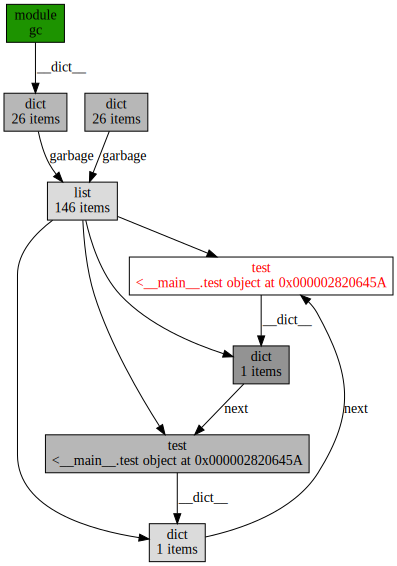

In [4]:
#这一句即主要是根据上面得到的编码进行看图，前提条件就是设置了gc.set_debug(gc.DEBUG_SAVEALL)，从而执行gc.collect()之后不会被真的清除
import objgraph
objgraph.show_backrefs(objgraph.at(0x000002820645ACF8), max_depth=5, filename = './obj.png') 
#对应编码是从上面看出来的
#max_depth表示要展示的深度，5一般够，不够再加大
#此时从红色部分看，可以看出红色周边的引用情况，从而确定谁引用了它，红色对象即为问题对象，从它入手

In [ ]:
#另外的，objgraph还有一些常用的函数
#show_most_common_types(limits = 10)   #打印实例最多的前N（limits）个对象
#比如：objgraph.show_most_common_types(20) 即查看实例最多的20个对象

#有一个show_growth()的函数，其作用是统计自上次调用以来增加得最多的对象，这个函数非常有利于发现潜在的内存泄露。
#函数内部调用了gc.collect()，因此即使有循环引用也不会对判断造成影响。
#但是它主要用于预判，对于循环引用的对象没法用它来找出

#故而debug的时候也可以使用它来进行debug
#即在最开始或者还没有问题的地方执行一下objgraph.show_growth()
#在有问题了之后再执行一下objgraph.show_growth()，中间不需要去刻意执行gc.collect()
#比如这里可以直接这样：
# objgraph.show_growth()
# block()
# objgraph.show_growth()

#当两个循环引用对象，a引用b，b引用a时，要删除，则需要将两个都删除，比如del a; del b；然后再执行gc.collect()